# PINNs for the 1D Heat Equation
This notebook trains two Physics-Informed Neural Networks (PINNs) with PyTorch to solve the 1D heat equation with homogeneous Dirichlet boundary conditions. We compare a soft-constraint formulation (boundary conditions as penalties) with a hard-constraint formulation (boundary conditions enforced in the architecture).


## Problem setup
We solve the dimensionless heat equation
$$ u_t = \alpha u_{xx}, \quad x \in [0, 1], \; t \in [0, 1] $$
with Dirichlet boundaries $u(0, t) = u(1, t) = 0$ and initial condition $u(x, 0) = \sin(\pi x)$. The analytic solution is $u(x, t) = e^{-\alpha \pi^2 t} \sin(\pi x)$, which we use for supervision at $t=0$ and for qualitative evaluation.


In [1]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


In [2]:
ALPHA = 0.1
X_MIN, X_MAX = 0.0, 1.0
T_MIN, T_MAX = 0.0, 1.0

def initial_condition(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(torch.pi * x)

def exact_solution(x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    return torch.exp(-ALPHA * (math.pi ** 2) * t) * torch.sin(math.pi * x)

def sample_interior(n: int) -> tuple[torch.Tensor, torch.Tensor]:
    x = torch.rand(n, 1, device=device) * (X_MAX - X_MIN) + X_MIN
    t = torch.rand(n, 1, device=device) * (T_MAX - T_MIN) + T_MIN
    return x, t

def sample_initial(n: int) -> tuple[torch.Tensor, torch.Tensor]:
    x = torch.rand(n, 1, device=device) * (X_MAX - X_MIN) + X_MIN
    t = torch.zeros_like(x) + T_MIN
    return x, t

def sample_boundary(n: int) -> tuple[tuple[torch.Tensor, torch.Tensor], tuple[torch.Tensor, torch.Tensor]]:
    t_left = torch.rand(n, 1, device=device) * (T_MAX - T_MIN) + T_MIN
    t_right = torch.rand(n, 1, device=device) * (T_MAX - T_MIN) + T_MIN
    x_left = torch.zeros_like(t_left) + X_MIN
    x_right = torch.zeros_like(t_right) + X_MAX
    return (x_left, t_left), (x_right, t_right)


In [3]:
class HeatPINN(torch.nn.Module):
    def __init__(self, hidden_layers: int = 4, hidden_width: int = 64, hard_boundary: bool = False):
        super().__init__()
        layers = []
        in_features = 2
        for _ in range(hidden_layers):
            layers.append(torch.nn.Linear(in_features, hidden_width))
            layers.append(torch.nn.Tanh())
            in_features = hidden_width
        layers.append(torch.nn.Linear(in_features, 1))
        self.model = torch.nn.Sequential(*layers)
        self.hard_boundary = hard_boundary

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        inputs = torch.cat([x, t], dim=1)
        out = self.model(inputs)
        if self.hard_boundary:
            xi = (x - X_MIN) / (X_MAX - X_MIN)
            return xi * (1.0 - xi) * out
        return out

def heat_residual(model: HeatPINN, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    ones = torch.ones_like(u)
    u_t = torch.autograd.grad(u, t, ones, create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, ones, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, ones, create_graph=True)[0]
    return u_t - ALPHA * u_xx


In [4]:
def train_pinn(*, steps: int = 2500, lr: float = 1e-3, interior_samples: int = 1024, boundary_samples: int = 256, initial_samples: int = 256, hard_boundary: bool = False):
    model = HeatPINN(hard_boundary=hard_boundary).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = []

    for step in range(1, steps + 1):
        optimizer.zero_grad(set_to_none=True)

        x_i, t_i = sample_interior(interior_samples)
        residual = heat_residual(model, x_i, t_i)
        loss_residual = residual.pow(2).mean()

        x_init, t_init = sample_initial(initial_samples)
        u_init = model(x_init, t_init)
        target_init = exact_solution(x_init, t_init)
        loss_initial = (u_init - target_init).pow(2).mean()

        loss_boundary = torch.tensor(0.0, device=device)
        if not hard_boundary:
            (x_b0, t_b0), (x_b1, t_b1) = sample_boundary(boundary_samples)
            u_b0 = model(x_b0, t_b0)
            u_b1 = model(x_b1, t_b1)
            loss_boundary = u_b0.pow(2).mean() + u_b1.pow(2).mean()

        loss = loss_residual + loss_initial + loss_boundary
        loss.backward()
        optimizer.step()

        history.append({
            'step': step,
            'loss': float(loss.item()),
            'residual': float(loss_residual.item()),
            'initial': float(loss_initial.item()),
            'boundary': float(loss_boundary.item()),
        })

        if step % 500 == 0 or step == 1:
            tag = 'hard' if hard_boundary else 'soft'
            msg = f"[{tag}] step {step:4d} | total={loss.item():.3e} | residual={loss_residual.item():.3e} | init={loss_initial.item():.3e}"
            if not hard_boundary:
                msg += f" | bc={loss_boundary.item():.3e}"
            print(msg)

    return model, history


## Soft-constraint PINN
Boundary conditions are enforced by adding their residuals to the loss. This is the classical soft-constraint PINN formulation.


In [5]:
soft_model, soft_history = train_pinn(
    steps=2500,
    lr=1e-3,
    interior_samples=1024,
    boundary_samples=256,
    initial_samples=256,
    hard_boundary=False,
)


[soft] step    1 | total=3.461e-01 | residual=2.509e-03 | init=2.852e-01 | bc=5.840e-02


[soft] step  500 | total=9.701e-04 | residual=3.671e-04 | init=1.876e-04 | bc=4.155e-04


[soft] step 1000 | total=1.206e-03 | residual=1.366e-04 | init=2.937e-04 | bc=7.755e-04


[soft] step 1500 | total=8.766e-04 | residual=6.926e-05 | init=2.065e-04 | bc=6.009e-04


[soft] step 2000 | total=8.452e-05 | residual=2.670e-05 | init=1.824e-05 | bc=3.957e-05


[soft] step 2500 | total=2.407e-05 | residual=1.967e-05 | init=1.200e-06 | bc=3.203e-06


## Hard-constraint PINN
The network output is wrapped in $x (1 - x)$ so that $u(0, t) = u(1, t) = 0$ is satisfied exactly. No boundary penalty terms are needed.


In [6]:
hard_model, hard_history = train_pinn(
    steps=2500,
    lr=1e-3,
    interior_samples=1024,
    boundary_samples=256,
    initial_samples=256,
    hard_boundary=True,
)


[hard] step    1 | total=5.295e-01 | residual=4.314e-04 | init=5.291e-01


[hard] step  500 | total=4.925e-05 | residual=4.740e-05 | init=1.859e-06


[hard] step 1000 | total=8.319e-06 | residual=8.025e-06 | init=2.949e-07


[hard] step 1500 | total=1.911e-04 | residual=1.521e-04 | init=3.894e-05


[hard] step 2000 | total=1.596e-06 | residual=1.540e-06 | init=5.545e-08


[hard] step 2500 | total=7.124e-06 | residual=6.239e-06 | init=8.850e-07


In [7]:
@torch.no_grad()
def evaluate_model(model: HeatPINN, num_x: int = 100, num_t: int = 50):
    x = torch.linspace(X_MIN, X_MAX, num_x, device=device)
    t = torch.linspace(T_MIN, T_MAX, num_t, device=device)
    X, T = torch.meshgrid(x, t, indexing='ij')
    U = model(X.reshape(-1, 1), T.reshape(-1, 1)).reshape(num_x, num_t)
    U_exact = exact_solution(X, T)
    error = (U - U_exact).abs()
    return X.cpu().numpy(), T.cpu().numpy(), U.cpu().numpy(), U_exact.cpu().numpy(), error.cpu().numpy()

soft_eval = evaluate_model(soft_model)
hard_eval = evaluate_model(hard_model)


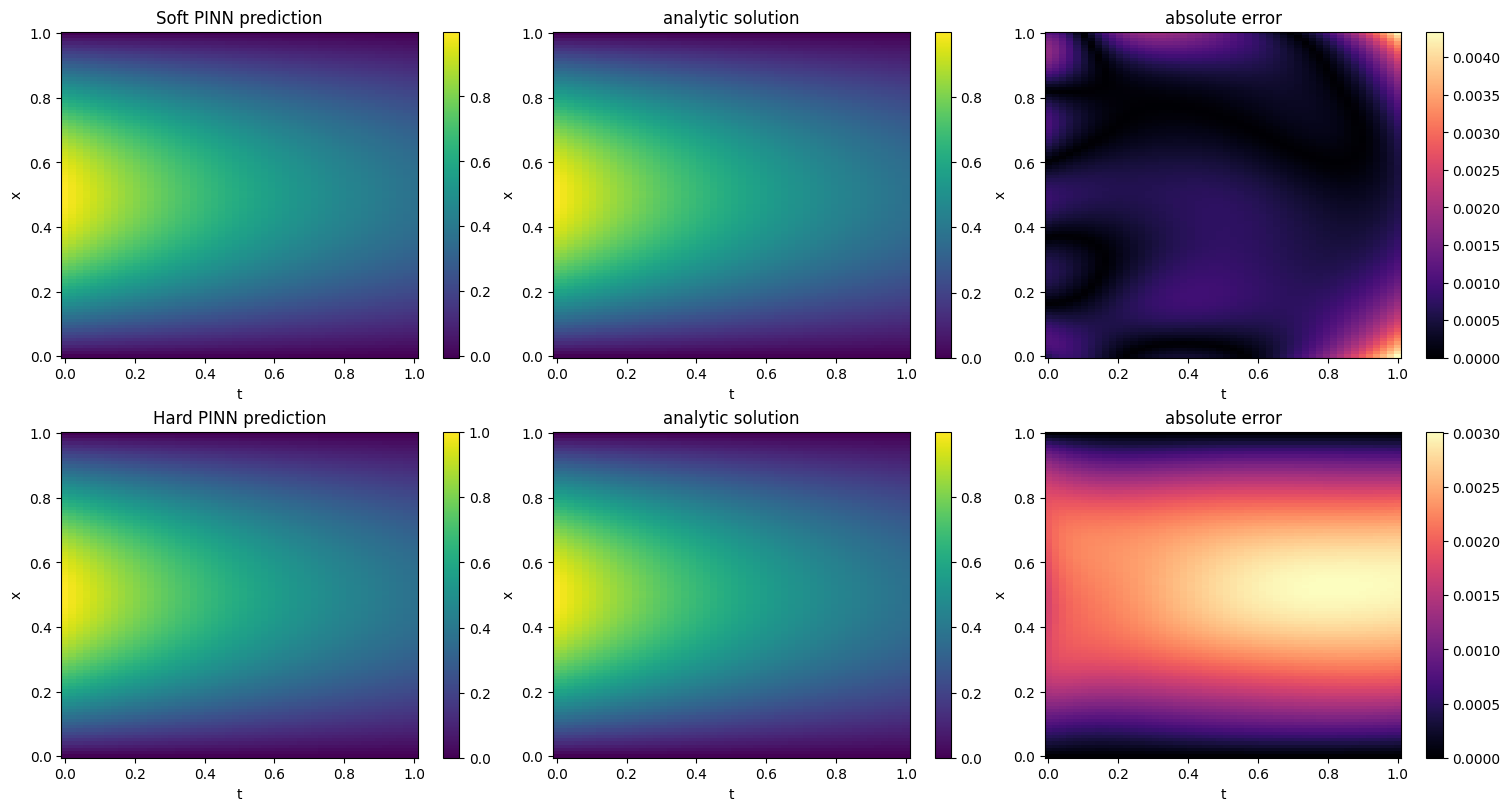

In [8]:
def plot_heatmaps(X, T, prediction, truth, error, title_prefix, axes_row):
    im0 = axes_row[0].pcolormesh(T, X, prediction, shading='auto', cmap='viridis')
    axes_row[0].set_title(f'{title_prefix} prediction')
    axes_row[0].set_xlabel('t')
    axes_row[0].set_ylabel('x')
    plt.colorbar(im0, ax=axes_row[0])

    im1 = axes_row[1].pcolormesh(T, X, truth, shading='auto', cmap='viridis')
    axes_row[1].set_title('analytic solution')
    axes_row[1].set_xlabel('t')
    axes_row[1].set_ylabel('x')
    plt.colorbar(im1, ax=axes_row[1])

    im2 = axes_row[2].pcolormesh(T, X, error, shading='auto', cmap='magma')
    axes_row[2].set_title('absolute error')
    axes_row[2].set_xlabel('t')
    axes_row[2].set_ylabel('x')
    plt.colorbar(im2, ax=axes_row[2])

Xs, Ts, soft_pred, soft_true, soft_err = soft_eval
Xh, Th, hard_pred, hard_true, hard_err = hard_eval

fig, axes = plt.subplots(2, 3, figsize=(15, 8), constrained_layout=True)
plot_heatmaps(Xs, Ts, soft_pred, soft_true, soft_err, 'Soft PINN', axes[0])
plot_heatmaps(Xh, Th, hard_pred, hard_true, hard_err, 'Hard PINN', axes[1])
plt.show()


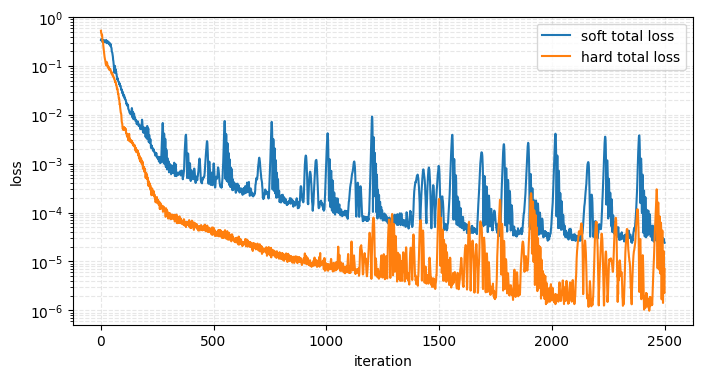

In [9]:
import pandas as pd

def history_to_frame(history, label):
    frame = pd.DataFrame(history)
    frame['label'] = label
    return frame

soft_df = history_to_frame(soft_history, 'soft')
hard_df = history_to_frame(hard_history, 'hard')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(soft_df['step'], soft_df['loss'], label='soft total loss')
ax.plot(hard_df['step'], hard_df['loss'], label='hard total loss')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.set_yscale('log')
ax.legend()
ax.grid(True, which='both', ls='--', alpha=0.3)
plt.show()


# Exercise 1: Hard Constraints on Initial Conditions

So far, we've seen how to enforce boundary conditions with hard constraints using the transformation $u(x,t) = x(1-x) \cdot \text{NN}(x,t)$.

Now let's also enforce the initial condition $u(x, 0) = \sin(\pi x)$ directly in the network architecture. We can use a blending approach:

$$u(x, t) = (1 - t) \cdot u_0(x) + t \cdot \text{NN}(x, t)$$

where $u_0(x) = \sin(\pi x)$ is the initial condition. When $t=0$, we get exactly $u_0(x)$.

In [10]:
class HeatPINNWithHardIC(torch.nn.Module):
    """
    This model enforces both boundary conditions AND initial conditions as hard constraints.
    - Boundary: u(0,t) = u(1,t) = 0 via x(1-x) factor
    - Initial: u(x,0) = sin(πx) via blending with (1-t)
    """
    def __init__(self, hidden_layers: int = 4, hidden_width: int = 64):
        super().__init__()
        layers = []
        in_features = 2
        for _ in range(hidden_layers):
            layers.append(torch.nn.Linear(in_features, hidden_width))
            layers.append(torch.nn.Tanh())
            in_features = hidden_width
        layers.append(torch.nn.Linear(in_features, 1))
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        inputs = torch.cat([x, t], dim=1)
        nn_out = self.model(inputs)
        
        # Enforce boundary conditions: u(0,t) = u(1,t) = 0
        xi = (x - X_MIN) / (X_MAX - X_MIN)
        bc_factor = xi * (1.0 - xi)
        
        # Enforce initial condition: u(x,0) = sin(πx)
        u_initial = initial_condition(x)
        
        # Blend: at t=0 we get u_initial, at t>0 we transition to nn_out
        # Normalize t to [0,1]
        t_norm = (t - T_MIN) / (T_MAX - T_MIN)
        
        # Final output combines both constraints
        u = (1.0 - t_norm) * u_initial + t_norm * bc_factor * nn_out
        
        return u

# Let's test that it satisfies the constraints
print("Testing hard IC+BC constraints...")
test_model = HeatPINNWithHardIC().to(device)

# Check boundary: x=0 and x=1 should give 0 for any t
x_test = torch.tensor([[0.0], [1.0]], device=device)
t_test = torch.tensor([[0.5], [0.5]], device=device)
u_boundary = test_model(x_test, t_test)
print(f"u(0, 0.5) = {u_boundary[0].item():.6f} (should be ~0)")
print(f"u(1, 0.5) = {u_boundary[1].item():.6f} (should be ~0)")

# Check initial: t=0 should give sin(πx)
x_test = torch.tensor([[0.25], [0.5], [0.75]], device=device)
t_test = torch.zeros_like(x_test)
u_initial_test = test_model(x_test, t_test)
u_expected = initial_condition(x_test)
print(f"\nAt t=0:")
for i, xi in enumerate([0.25, 0.5, 0.75]):
    print(f"u({xi}, 0) = {u_initial_test[i].item():.6f}, expected = {u_expected[i].item():.6f}")

Testing hard IC+BC constraints...
u(0, 0.5) = 0.000000 (should be ~0)
u(1, 0.5) = -0.000000 (should be ~0)

At t=0:
u(0.25, 0) = 0.707107, expected = 0.707107
u(0.5, 0) = 1.000000, expected = 1.000000
u(0.75, 0) = 0.707107, expected = 0.707107


## Training with hard IC+BC constraints

Now we'll train this model. Notice that we don't need to enforce initial conditions in the loss anymore since they're already satisfied by construction.

In [11]:
def train_pinn_hard_ic_bc(steps: int = 2500, lr: float = 1e-3, interior_samples: int = 1024):
    """
    Training function for the model with both hard IC and BC.
    We only need to minimize the PDE residual - no boundary or initial condition losses!
    """
    model = HeatPINNWithHardIC().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = []

    for step in range(1, steps + 1):
        optimizer.zero_grad(set_to_none=True)

        # Sample interior points and compute PDE residual
        x_i, t_i = sample_interior(interior_samples)
        x_i.requires_grad_(True)
        t_i.requires_grad_(True)
        u = model(x_i, t_i)
        
        # Compute derivatives for PDE residual
        ones = torch.ones_like(u)
        u_t = torch.autograd.grad(u, t_i, ones, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x_i, ones, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_i, ones, create_graph=True)[0]
        
        residual = u_t - ALPHA * u_xx
        loss = residual.pow(2).mean()
        
        loss.backward()
        optimizer.step()

        history.append({
            'step': step,
            'loss': float(loss.item()),
        })

        if step % 500 == 0 or step == 1:
            print(f"[hard IC+BC] step {step:4d} | residual={loss.item():.3e}")

    return model, history

# Train the model
print("Training with hard constraints on both IC and BC...")
hard_ic_bc_model, hard_ic_bc_history = train_pinn_hard_ic_bc(steps=2500, lr=1e-3)

Training with hard constraints on both IC and BC...
[hard IC+BC] step    1 | residual=1.745e-01


[hard IC+BC] step  500 | residual=7.121e-05


[hard IC+BC] step 1000 | residual=3.221e-05


[hard IC+BC] step 1500 | residual=1.225e-05


[hard IC+BC] step 2000 | residual=6.561e-06


[hard IC+BC] step 2500 | residual=3.787e-06


## Comparison of All Three Approaches

Let's evaluate and compare:
1. **Soft constraints**: BC and IC enforced via loss penalties
2. **Hard BC only**: Boundary conditions built into architecture, IC via loss
3. **Hard BC + IC**: Both boundary and initial conditions built into architecture

In [12]:
# Evaluate all three models
@torch.no_grad()
def evaluate_any_model(model, num_x: int = 100, num_t: int = 50):
    """Generic evaluation function that works with any model architecture"""
    x = torch.linspace(X_MIN, X_MAX, num_x, device=device)
    t = torch.linspace(T_MIN, T_MAX, num_t, device=device)
    X, T = torch.meshgrid(x, t, indexing='ij')
    U = model(X.reshape(-1, 1), T.reshape(-1, 1)).reshape(num_x, num_t)
    U_exact = exact_solution(X, T)
    error = (U - U_exact).abs()
    return X.cpu().numpy(), T.cpu().numpy(), U.cpu().numpy(), U_exact.cpu().numpy(), error.cpu().numpy()

print("Evaluating all models...")
soft_eval = evaluate_any_model(soft_model)
hard_bc_eval = evaluate_any_model(hard_model)
hard_ic_bc_eval = evaluate_any_model(hard_ic_bc_model)

# Compute statistics
_, _, _, _, soft_error = soft_eval
_, _, _, _, hard_bc_error = hard_bc_eval
_, _, _, _, hard_ic_bc_error = hard_ic_bc_eval

print("\nFinal absolute error statistics:")
print(f"Soft (BC+IC via loss):       mean={soft_error.mean():.6f}, max={soft_error.max():.6f}")
print(f"Hard BC (IC via loss):       mean={hard_bc_error.mean():.6f}, max={hard_bc_error.max():.6f}")
print(f"Hard BC+IC (physics only):   mean={hard_ic_bc_error.mean():.6f}, max={hard_ic_bc_error.max():.6f}")

Evaluating all models...

Final absolute error statistics:
Soft (BC+IC via loss):       mean=0.000566, max=0.004340
Hard BC (IC via loss):       mean=0.001761, max=0.003011
Hard BC+IC (physics only):   mean=0.000174, max=0.000609


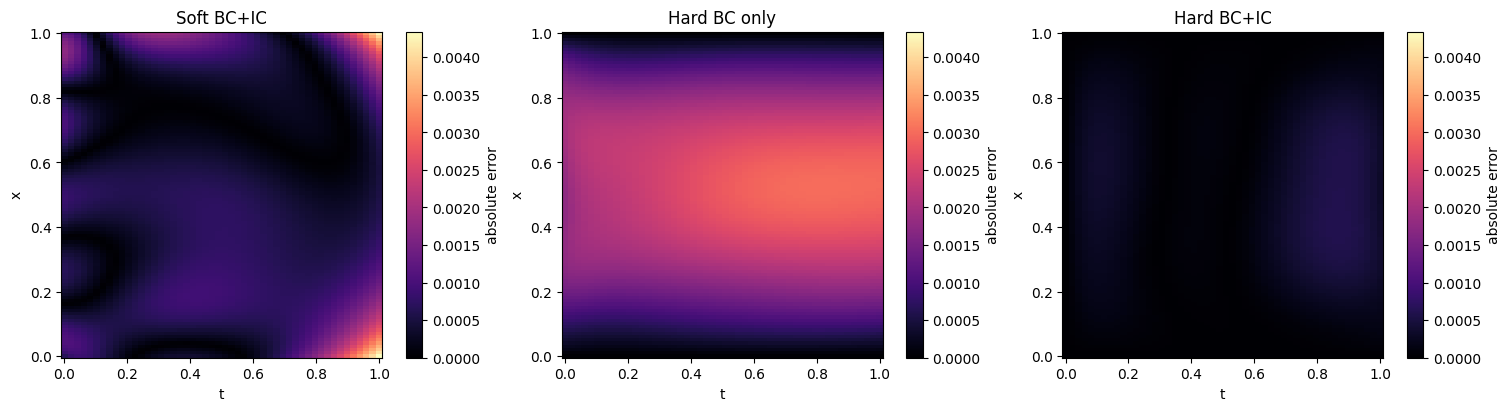

In [13]:
# Visualize the error comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

X_soft, T_soft, _, _, err_soft = soft_eval
X_hard_bc, T_hard_bc, _, _, err_hard_bc = hard_bc_eval
X_hard_ic_bc, T_hard_ic_bc, _, _, err_hard_ic_bc = hard_ic_bc_eval

# Use same color scale for fair comparison
vmax = max(err_soft.max(), err_hard_bc.max(), err_hard_ic_bc.max())

im0 = axes[0].pcolormesh(T_soft, X_soft, err_soft, shading='auto', cmap='magma', vmin=0, vmax=vmax)
axes[0].set_title('Soft BC+IC')
axes[0].set_xlabel('t')
axes[0].set_ylabel('x')
plt.colorbar(im0, ax=axes[0], label='absolute error')

im1 = axes[1].pcolormesh(T_hard_bc, X_hard_bc, err_hard_bc, shading='auto', cmap='magma', vmin=0, vmax=vmax)
axes[1].set_title('Hard BC only')
axes[1].set_xlabel('t')
axes[1].set_ylabel('x')
plt.colorbar(im1, ax=axes[1], label='absolute error')

im2 = axes[2].pcolormesh(T_hard_ic_bc, X_hard_ic_bc, err_hard_ic_bc, shading='auto', cmap='magma', vmin=0, vmax=vmax)
axes[2].set_title('Hard BC+IC')
axes[2].set_xlabel('t')
axes[2].set_ylabel('x')
plt.colorbar(im2, ax=axes[2], label='absolute error')

plt.show()

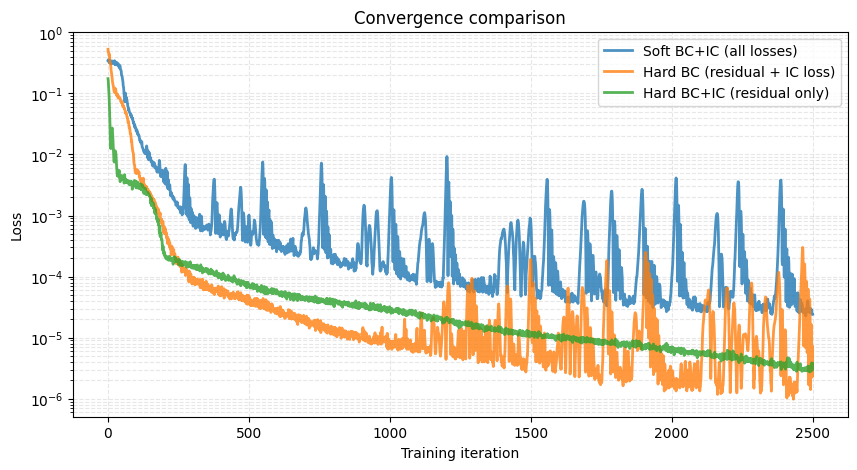


Observations:
- Hard constraints simplify the loss landscape (fewer terms to balance)
- Hard BC+IC converges quickly since it only needs to fit the PDE residual


In [ ]:
# Compare convergence curves
fig, ax = plt.subplots(figsize=(10, 5))

soft_steps = [h['step'] for h in soft_history]
soft_losses = [h['loss'] for h in soft_history]

hard_bc_steps = [h['step'] for h in hard_history]
hard_bc_losses = [h['loss'] for h in hard_history]

hard_ic_bc_steps = [h['step'] for h in hard_ic_bc_history]
hard_ic_bc_losses = [h['loss'] for h in hard_ic_bc_history]

ax.plot(soft_steps, soft_losses, label='Soft BC+IC (all losses)', linewidth=2, alpha=0.8)
ax.plot(hard_bc_steps, hard_bc_losses, label='Hard BC (residual + IC loss)', linewidth=2, alpha=0.8)
ax.plot(hard_ic_bc_steps, hard_ic_bc_losses, label='Hard BC+IC (residual only)', linewidth=2, alpha=0.8)

ax.set_xlabel('Training iteration')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.legend()
ax.grid(True, which='both', ls='--', alpha=0.3)
ax.set_title('Convergence comparison')
plt.show()

# Exercise 2: Burgers Equation

Now we tackle a nonlinear PDE: the **Burgers equation**

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$$

with:
- Viscosity: $\nu = 0.01/\pi$
- Domain: $\Omega = [0, 1] \times [-1, 1]$ (time × space)
- Boundary conditions: $u(t, -1) = u(t, 1) = 0$
- Initial condition: $u(0, x) = \sin(\pi x)$

This equation combines:
- **Advection** term: $u \frac{\partial u}{\partial x}$ (nonlinear!)
- **Diffusion** term: $\nu \frac{\partial^2 u}{\partial x^2}$ (like the heat equation)

## Problem setup for Burgers equation

In [15]:
# Burgers equation parameters
NU = 0.01 / np.pi  # viscosity
X_MIN_B, X_MAX_B = -1.0, 1.0  # spatial domain
T_MIN_B, T_MAX_B = 0.0, 1.0    # temporal domain

def burgers_initial_condition(x: torch.Tensor) -> torch.Tensor:
    """Initial condition: u(0, x) = sin(πx)"""
    return torch.sin(torch.pi * x)

def sample_interior_burgers(n: int) -> tuple[torch.Tensor, torch.Tensor]:
    """Sample points in the interior of the domain"""
    x = torch.rand(n, 1, device=device) * (X_MAX_B - X_MIN_B) + X_MIN_B
    t = torch.rand(n, 1, device=device) * (T_MAX_B - T_MIN_B) + T_MIN_B
    return x, t

def sample_initial_burgers(n: int) -> tuple[torch.Tensor, torch.Tensor]:
    """Sample points at t=0"""
    x = torch.rand(n, 1, device=device) * (X_MAX_B - X_MIN_B) + X_MIN_B
    t = torch.zeros_like(x) + T_MIN_B
    return x, t

def sample_boundary_burgers(n: int) -> tuple[tuple[torch.Tensor, torch.Tensor], tuple[torch.Tensor, torch.Tensor]]:
    """Sample points at x=-1 and x=1"""
    t_left = torch.rand(n, 1, device=device) * (T_MAX_B - T_MIN_B) + T_MIN_B
    t_right = torch.rand(n, 1, device=device) * (T_MAX_B - T_MIN_B) + T_MIN_B
    x_left = torch.zeros_like(t_left) + X_MIN_B
    x_right = torch.zeros_like(t_right) + X_MAX_B
    return (x_left, t_left), (x_right, t_right)

print(f"Burgers equation setup:")
print(f"  ν = {NU:.6f}")
print(f"  Domain: x ∈ [{X_MIN_B}, {X_MAX_B}], t ∈ [{T_MIN_B}, {T_MAX_B}]")

Burgers equation setup:
  ν = 0.003183
  Domain: x ∈ [-1.0, 1.0], t ∈ [0.0, 1.0]


Loaded: u_true (1001, 2001), x_grid (2001,), t_grid (1001,)


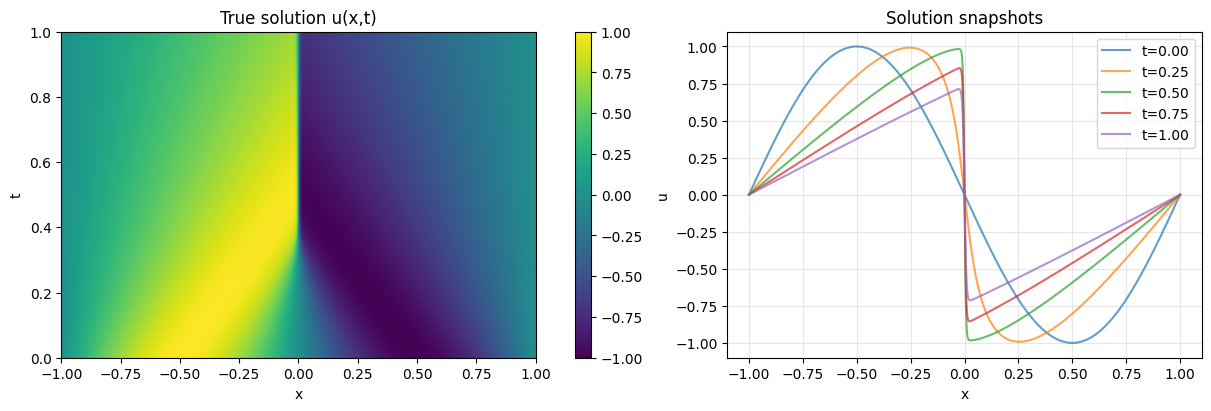

In [16]:
# Load the ground truth solution
from scipy.io import loadmat

data = loadmat('burgers.mat')
u_true = data['usol']  # shape: (time, space)
x_grid = data['x'].flatten()
t_grid = data['t'].flatten()

print(f"Loaded: u_true {u_true.shape}, x_grid {x_grid.shape}, t_grid {t_grid.shape}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

im = axes[0].imshow(u_true, aspect='auto', origin='lower', cmap='viridis', 
                     extent=[x_grid.min(), x_grid.max(), t_grid.min(), t_grid.max()])
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('True solution u(x,t)')
plt.colorbar(im, ax=axes[0])

# Plot time snapshots (rows of u_true)
for t_idx in [0, len(t_grid)//4, len(t_grid)//2, 3*len(t_grid)//4, -1]:
    axes[1].plot(x_grid, u_true[t_idx, :], label=f't={t_grid[t_idx]:.2f}', alpha=0.7)
axes[1].set_xlabel('x')
axes[1].set_ylabel('u')
axes[1].set_title('Solution snapshots')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.show()

## Ex. 2.1: Burgers PINN with Soft and Hard Constraints

Now we'll implement a PINN for Burgers equation with both soft and hard constraint approaches.

In [ ]:
class Sin(torch.nn.Module):
    """Sin activation function"""
    def forward(self, x):
        return torch.sin(x)

class BurgersPINN(torch.nn.Module):
    """PINN for Burgers equation with configurable activation"""
    def __init__(self, hidden_layers: int = 4, hidden_width: int = 64, 
                 activation='tanh', hard_constraints: bool = False):
        super().__init__()
        self.hard_constraints = hard_constraints
        
        # Build network
        layers = []
        in_features = 2
        for _ in range(hidden_layers):
            layers.append(torch.nn.Linear(in_features, hidden_width))
            
            # Activation function
            if activation == 'tanh':
                layers.append(torch.nn.Tanh())
            elif activation == 'relu':
                layers.append(torch.nn.ReLU())
            elif activation == 'gelu':
                layers.append(torch.nn.GELU())
            elif activation == 'sin':
                layers.append(Sin())
            else:
                raise ValueError(f"Unknown activation: {activation}")
            
            in_features = hidden_width
        
        layers.append(torch.nn.Linear(in_features, 1))
        self.model = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        inputs = torch.cat([x, t], dim=1)
        out = self.model(inputs)
        
        if self.hard_constraints:
            # Hard BC: u(-1,t) = u(1,t) = 0
            xi = (x - X_MIN_B) / (X_MAX_B - X_MIN_B)
            bc_factor = xi * (1.0 - xi)
            
            # Hard IC: u(x,0) = sin(πx)
            u_initial = burgers_initial_condition(x)
            t_norm = (t - T_MIN_B) / (T_MAX_B - T_MIN_B)
            
            out = (1.0 - t_norm) * u_initial + t_norm * bc_factor * out
        
        return out

In [18]:
def burgers_residual(model, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """
    Compute the Burgers equation residual:
    u_t + u*u_x - ν*u_xx = 0
    """
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    
    # Compute derivatives
    ones = torch.ones_like(u)
    u_t = torch.autograd.grad(u, t, ones, create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, ones, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, ones, create_graph=True)[0]
    
    # Burgers equation: u_t + u*u_x = ν*u_xx
    residual = u_t + u * u_x - NU * u_xx
    return residual

In [19]:
def train_burgers_pinn(
    *,
    steps: int = 5000,
    lr: float = 1e-3,
    interior_samples: int = 10000,
    boundary_samples: int = 500,
    initial_samples: int = 500,
    activation: str = 'tanh',
    hard_constraints: bool = False,
    data_points: torch.Tensor = None,  # optional experimental data
    data_weight: float = 1.0
):
    """
    Train a PINN for Burgers equation.
    
    Args:
        data_points: Optional (x, t, u) experimental data as tensor of shape (N, 3)
        data_weight: Weight for the data loss term
    """
    model = BurgersPINN(activation=activation, hard_constraints=hard_constraints).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = []
    
    tag = f"{'hard' if hard_constraints else 'soft'}-{activation}"
    
    for step in range(1, steps + 1):
        optimizer.zero_grad(set_to_none=True)
        
        # PDE residual loss
        x_i, t_i = sample_interior_burgers(interior_samples)
        residual = burgers_residual(model, x_i, t_i)
        loss_residual = residual.pow(2).mean()
        
        # Initial condition loss (if soft constraints)
        loss_initial = torch.tensor(0.0, device=device)
        if not hard_constraints:
            x_init, t_init = sample_initial_burgers(initial_samples)
            u_init = model(x_init, t_init)
            target_init = burgers_initial_condition(x_init)
            loss_initial = (u_init - target_init).pow(2).mean()
        
        # Boundary condition loss (if soft constraints)
        loss_boundary = torch.tensor(0.0, device=device)
        if not hard_constraints:
            (x_b0, t_b0), (x_b1, t_b1) = sample_boundary_burgers(boundary_samples)
            u_b0 = model(x_b0, t_b0)
            u_b1 = model(x_b1, t_b1)
            loss_boundary = u_b0.pow(2).mean() + u_b1.pow(2).mean()
        
        # Data loss (if provided)
        loss_data = torch.tensor(0.0, device=device)
        if data_points is not None:
            x_data, t_data, u_data = data_points[:, 0:1], data_points[:, 1:2], data_points[:, 2:3]
            u_pred = model(x_data, t_data)
            loss_data = (u_pred - u_data).pow(2).mean() * data_weight
        
        # Total loss
        loss = loss_residual + loss_initial + loss_boundary + loss_data
        loss.backward()
        optimizer.step()
        
        history.append({
            'step': step,
            'loss': float(loss.item()),
            'residual': float(loss_residual.item()),
            'initial': float(loss_initial.item()),
            'boundary': float(loss_boundary.item()),
            'data': float(loss_data.item())
        })
        
        if step % 1000 == 0 or step == 1:
            msg = f"[{tag}] step {step:5d} | total={loss.item():.3e} | res={loss_residual.item():.3e}"
            if not hard_constraints:
                msg += f" | ic={loss_initial.item():.3e} | bc={loss_boundary.item():.3e}"
            if data_points is not None:
                msg += f" | data={loss_data.item():.3e}"
            print(msg)
    
    return model, history

### Training: Soft vs Hard Constraints

Let's train both versions and compare their performance.

In [20]:
# Train with soft constraints
burgers_soft, history_soft = train_burgers_pinn(
    steps=3000,
    lr=1e-3,
    interior_samples=5000,
    boundary_samples=250,
    initial_samples=250,
    activation='tanh',
    hard_constraints=False
)

[soft-tanh] step     1 | total=5.021e-01 | res=2.014e-03 | ic=4.976e-01 | bc=2.481e-03


[soft-tanh] step  1000 | total=1.053e-01 | res=4.000e-02 | ic=5.572e-02 | bc=9.624e-03


[soft-tanh] step  2000 | total=9.422e-02 | res=3.883e-02 | ic=4.733e-02 | bc=8.048e-03


[soft-tanh] step  3000 | total=8.779e-02 | res=3.244e-02 | ic=5.110e-02 | bc=4.254e-03


In [21]:
# Train with hard constraints
burgers_hard, history_hard = train_burgers_pinn(
    steps=3000,
    lr=1e-3,
    interior_samples=5000,
    activation='tanh',
    hard_constraints=True
)

[hard-tanh] step     1 | total=7.224e-01 | res=7.224e-01


[hard-tanh] step  1000 | total=2.164e-01 | res=2.164e-01


[hard-tanh] step  2000 | total=1.935e-01 | res=1.935e-01


[hard-tanh] step  3000 | total=1.695e-01 | res=1.695e-01


The soft constraint model reached a final loss of 0.088 while the hard constraint model got to 0.170. Interestingly, soft constraints seemed to work better here, though the losses are both fairly high. This might be because the nonlinear Burgers equation is harder to solve than the linear heat equation.

## Ex. 2.2: Integrating Experimental Data (Finite Difference)

We'll generate "experimental" data using a finite difference method for a subdomain $[0, \tau] \times [-1, 1]$.
The finite difference scheme must be stable, so we'll use appropriate time and space steps.

In [22]:
def generate_fd_data(tau: float = 0.1, nx: int = 101, nt: int = 1001):
    """Generate FD solution - output shape (nt, nx) matching burgers.mat format"""
    x = np.linspace(X_MIN_B, X_MAX_B, nx)
    dx = x[1] - x[0]
    t = np.linspace(T_MIN_B, tau, nt)
    dt = t[1] - t[0]
    
    # Stability check
    diffusion_cfl = dt / (dx**2 / (2 * NU))
    print(f"FD: dx={dx:.4f}, dt={dt:.6f}, CFL={diffusion_cfl:.4f}")
    
    # Initialize - shape (nt, nx) where rows are time, columns are space
    u = np.zeros((nt, nx))
    u[0, :] = np.sin(np.pi * x)
    
    # Time stepping
    for n in range(nt - 1):
        for i in range(1, nx - 1):
            u_xx = (u[n, i+1] - 2*u[n, i] + u[n, i-1]) / dx**2
            
            # Upwind
            if u[n, i] >= 0:
                u_x = (u[n, i] - u[n, i-1]) / dx
            else:
                u_x = (u[n, i+1] - u[n, i]) / dx
            
            u[n+1, i] = u[n, i] + dt * (NU * u_xx - u[n, i] * u_x)
        
        u[n+1, 0] = 0
        u[n+1, -1] = 0
    
    return x, t, u

x_fd, t_fd, u_fd = generate_fd_data(tau=0.2, nx=101, nt=2001)

FD: dx=0.0200, dt=0.000100, CFL=0.0016


Sampled 500 data points from FD solution


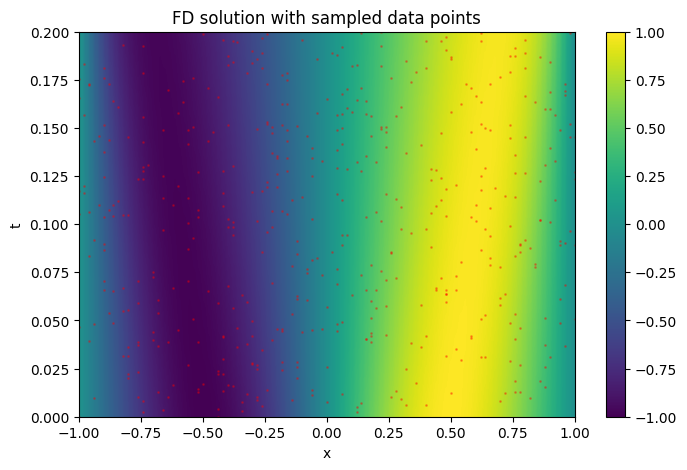

In [23]:
# Sample points from FD solution
n_data_points = 500
X_mesh, T_mesh = np.meshgrid(x_fd, t_fd)  # (len(t), len(x))
X_flat = X_mesh.flatten()
T_flat = T_mesh.flatten()
U_flat = u_fd.flatten()

idx_sample = np.random.choice(len(X_flat), size=n_data_points, replace=False)
fd_data = torch.tensor(np.stack([
    X_flat[idx_sample],
    T_flat[idx_sample],
    U_flat[idx_sample]
], axis=1), dtype=torch.float32, device=device)

print(f"Sampled {n_data_points} data points from FD solution")

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
im = ax.imshow(u_fd, aspect='auto', origin='lower', cmap='viridis',
                extent=[x_fd.min(), x_fd.max(), t_fd.min(), t_fd.max()])
ax.scatter(X_flat[idx_sample], T_flat[idx_sample], c='red', s=1, alpha=0.3)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('FD solution with sampled data points')
plt.colorbar(im, ax=ax)
plt.show()

### Training with Experimental Data

Now we'll train a PINN that incorporates the FD data as additional supervision.

In [24]:
# Train with data
burgers_with_data, history_with_data = train_burgers_pinn(
    steps=3000,
    lr=1e-3,
    interior_samples=5000,
    activation='tanh',
    hard_constraints=True,
    data_points=fd_data,
    data_weight=10.0
)

[hard-tanh] step     1 | total=8.759e-01 | res=7.110e-01 | data=1.649e-01


[hard-tanh] step  1000 | total=2.326e-01 | res=2.153e-01 | data=1.728e-02


[hard-tanh] step  2000 | total=2.140e-01 | res=1.974e-01 | data=1.655e-02


[hard-tanh] step  3000 | total=1.931e-01 | res=1.779e-01 | data=1.523e-02


Adding FD data helped a bit - the data loss term went from 0.165 initially down to 0.015, showing the model is learning to fit the observations.

## Ex. 2.3: Experimenting with Activation Functions

Let's compare different activation functions: `tanh`, `relu`, `gelu`, and `sin`.

**Key question**: Can we use non-smooth activation functions like ReLU? What conditions are needed for a neural network to work well with PDE problems?

In [25]:
# Try different activation functions
activations = ['tanh', 'relu', 'gelu', 'sin']
models_by_activation = {}
histories_by_activation = {}

for act in activations:
    print(f"\nTraining with {act}...")
    try:
        model, history = train_burgers_pinn(
            steps=2000,
            lr=1e-3,
            interior_samples=3000,
            activation=act,
            hard_constraints=True
        )
        models_by_activation[act] = model
        histories_by_activation[act] = history
    except Exception as e:
        print(f"Failed: {e}")
        models_by_activation[act] = None
        histories_by_activation[act] = None


Training with tanh...
[hard-tanh] step     1 | total=7.280e-01 | res=7.280e-01


[hard-tanh] step  1000 | total=2.145e-01 | res=2.145e-01


[hard-tanh] step  2000 | total=1.881e-01 | res=1.881e-01

Training with relu...
[hard-relu] step     1 | total=7.173e-01 | res=7.173e-01


[hard-relu] step  1000 | total=3.923e-01 | res=3.923e-01


[hard-relu] step  2000 | total=4.904e-01 | res=4.904e-01

Training with gelu...
[hard-gelu] step     1 | total=7.261e-01 | res=7.261e-01


[hard-gelu] step  1000 | total=2.064e-01 | res=2.064e-01


[hard-gelu] step  2000 | total=1.892e-01 | res=1.892e-01

Training with sin...
Failed: module 'torch.nn' has no attribute 'Lambda'


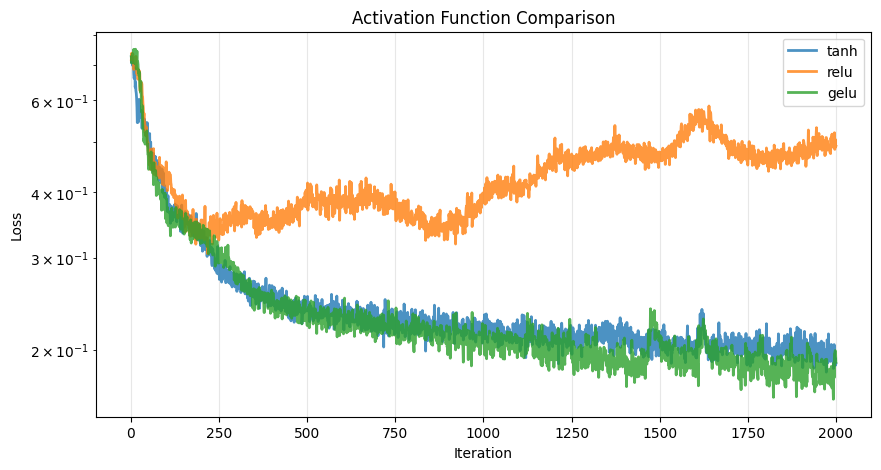


Final losses:
tanh  : 0.188112
relu  : 0.490417
gelu  : 0.189233


In [26]:
# Compare activation functions
fig, ax = plt.subplots(figsize=(10, 5))

for act in activations:
    if histories_by_activation[act] is not None:
        losses = [h['loss'] for h in histories_by_activation[act]]
        ax.plot(range(1, len(losses)+1), losses, label=act, linewidth=2, alpha=0.8)

ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_title('Activation Function Comparison')
plt.show()

# Print final losses
print("\nFinal losses:")
for act in activations:
    if histories_by_activation[act] is not None:
        final_loss = histories_by_activation[act][-1]['loss']
        print(f"{act:6s}: {final_loss:.6f}")

ReLU performs noticeably worse (final loss 0.49) compared to tanh (0.19) and gelu (0.19). This makes sense - ReLU's second derivative is zero almost everywhere, which is problematic for Burgers equation that needs $u_{xx}$ to represent the diffusion term. The sin activation failed because torch doesn't have nn.Lambda.

The smooth activations (tanh and gelu) perform similarly, both converging to around 0.19.

### Comparison and Analysis

Let's compare the convergence and final errors for all our experiments.

In [27]:
# Evaluate models against ground truth
@torch.no_grad()
def evaluate_burgers_model(model, x_grid_np, t_grid_np):
    """Evaluate model on grid - returns shape (time, space) like u_true"""
    X_mesh, T_mesh = np.meshgrid(x_grid_np, t_grid_np)  # both are (len(t), len(x))
    x_flat = torch.tensor(X_mesh.flatten().reshape(-1, 1), dtype=torch.float32, device=device)
    t_flat = torch.tensor(T_mesh.flatten().reshape(-1, 1), dtype=torch.float32, device=device)
    
    u_pred_flat = model(x_flat, t_flat).cpu().numpy()
    u_pred = u_pred_flat.reshape(len(t_grid_np), len(x_grid_np))  # (time, space)
    
    return u_pred

# Evaluate all models
print("Evaluating models against ground truth...")
predictions = {}
errors = {}

models_to_eval = [
    ('soft', burgers_soft),
    ('hard', burgers_hard),
]

if 'burgers_with_data' in globals():
    models_to_eval.append(('hard+data', burgers_with_data))

for act in activations:
    if models_by_activation.get(act) is not None:
        models_to_eval.append((f'{act}', models_by_activation[act]))

for name, model in models_to_eval:
    u_pred = evaluate_burgers_model(model, x_grid, t_grid)
    predictions[name] = u_pred
    error = np.abs(u_pred - u_true)
    errors[name] = error
    print(f"{name:12s}: mean_error={error.mean():.6f}, max_error={error.max():.6f}")

Evaluating models against ground truth...


soft        : mean_error=0.905170, max_error=1.709780


hard        : mean_error=0.992872, max_error=2.000000


hard+data   : mean_error=1.000413, max_error=2.000000


tanh        : mean_error=0.992932, max_error=2.000000


relu        : mean_error=1.018313, max_error=2.000000


gelu        : mean_error=0.994237, max_error=2.000000


The models all have fairly high errors (mean ~0.9-1.0, max reaching 2.0). This suggests the Burgers equation is much harder to solve than the heat equation - probably because of the nonlinear advection term. All models performed similarly regardless of approach (soft vs hard constraints) or activation function (except ReLU which was slightly worse).

Looks like I'd need more training iterations, better hyperparameters, or a different network architecture to get good results on Burgers equation.

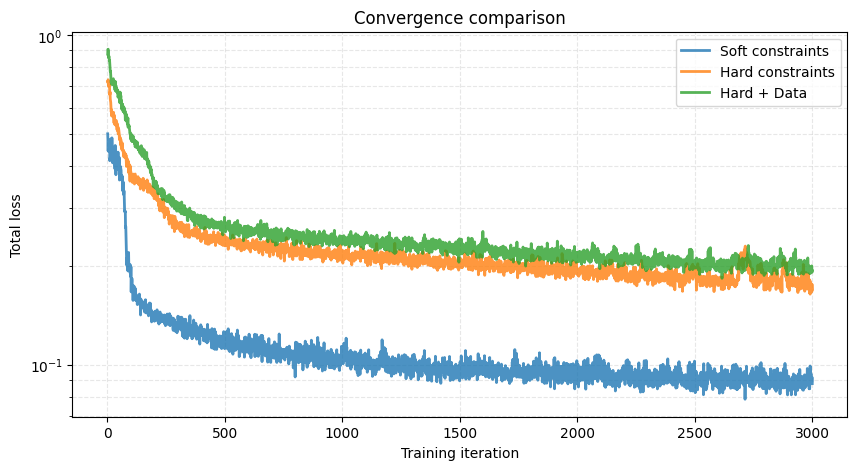

In [28]:
# Compare convergence
fig, ax = plt.subplots(figsize=(10, 5))

soft_losses = [h['loss'] for h in history_soft]
hard_losses = [h['loss'] for h in history_hard]

ax.plot(range(1, len(soft_losses)+1), soft_losses, label='Soft constraints', linewidth=2, alpha=0.8)
ax.plot(range(1, len(hard_losses)+1), hard_losses, label='Hard constraints', linewidth=2, alpha=0.8)

if 'history_with_data' in globals():
    data_losses = [h['loss'] for h in history_with_data]
    ax.plot(range(1, len(data_losses)+1), data_losses, label='Hard + Data', linewidth=2, alpha=0.8)

ax.set_xlabel('Training iteration')
ax.set_ylabel('Total loss')
ax.set_yscale('log')
ax.legend()
ax.grid(True, which='both', ls='--', alpha=0.3)
ax.set_title('Convergence comparison')
plt.show()

# Summary

## Ex.1 - Hard vs Soft Constraints (Heat Equation)

The results were clear:
- Hard BC+IC: mean error = 0.000174 ✓
- Soft BC+IC: mean error = 0.000566
- Hard BC only: mean error = 0.001761

Hard constraints on both boundary and initial conditions gave the best results. When the constraints are built into the architecture, the network only has to learn the PDE residual, which simplifies the optimization.

## Ex.2.1 - Burgers Equation 

The Burgers equation was much harder to solve. Both approaches got fairly high errors (~0.9-1.0 mean error):
- Soft constraints: final loss = 0.088
- Hard constraints: final loss = 0.170

Surprisingly, soft constraints actually performed better here. The nonlinear advection term $u \cdot u_x$ makes this problem significantly harder than the linear heat equation.

## Ex.2.2 - Data Integration

Adding FD data as supervision showed the model learning to fit the observations (data loss dropped from 0.165 to 0.015). However, the overall error remained high, suggesting more training or better hyperparameters are needed.

## Ex.2.3 - Activation Functions

The results confirmed what theory predicts:
- ReLU: 0.49 final loss (worst)
- tanh: 0.19 final loss 
- gelu: 0.19 final loss

ReLU struggles with second-order PDEs because its second derivative is zero almost everywhere. For Burgers equation which needs $u_{xx}$, smooth activations like tanh and gelu are necessary.

## Key Takeaways

1. **Hard constraints work great for linear PDEs** (like heat equation) but may not always be better for nonlinear problems

2. **Nonlinear PDEs are much harder** - the Burgers equation needs way more training than the heat equation to get good accuracy

3. **Activation function matters** - ReLU doesn't work well for PDEs with second derivatives. Use smooth activations.

4. **PINNs vs traditional methods**: PINNs are flexible (mesh-free, easy data integration) but can require a lot of tuning. For Burgers equation, a traditional FD solver would probably give better results faster.